In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import cmath
from math import floor
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.style.use('ggplot')

In [40]:
def gen_sinusoid(frequency, phase, amplitude=1, sample_rate=64, seq_length=64, gen_function=np.cos): 
    
    # get a vector of indices representing the positions in the sequence we want to generate
    nsteps = np.array(range(seq_length))
    
    # calculate the time each sample takes given the sampling rate
    sample_time = 1/sample_rate
    time_steps = sample_time * nsteps
    
    # A sinusoid's wave length (aka period) is how long it takes to complete one cycle (in seconds)
    # which is just the inverse of the frequency.
    wavelen = 1/frequency 
    
    # Now we can calculate how many samples it will take to complete one cycle:
    samples_per_cycle = wavelen/sample_time
    
    # 1 cycle = 2pi radians. So if it takes samples_per_cycle steps to complete a cycle, 
    # we need each sample to correspond to 2pi/samples_per_cycle radians: 
    theta_step = 2*np.pi/samples_per_cycle
    
    # Calculate all the angle (theta) values for our desired sequence:
    theta_steps = theta_step * nsteps

    # Calculate the function for that sequence of angles with given phase adjustment
    # We made the actual function a variable so we can swap between sin and cos as we like. 
    
    x = amplitude * gen_function(theta_steps + phase)
    
    return x, time_steps

In [41]:
def make_impulse_train(sample_rate, frequency, n_samples):    
    # make an arrange of n_samples, all zeros to start
    x = np.zeros(n_samples)
    
    # Determine where the impulses go based on the sample rate
    # The time between samples: sample_time = 1/sample_rate
    
    #A frequency of f cycles/second means the wavelength=1/f
    # So samples_per_cycle = wavelength/t_s = 1/frequency / 1/sample_rate = sample_rate/frequency
    
    ## We need to round to the nearest integer
    samples_per_cycle = round(sample_rate/frequency)
    
    # Set indices for impulses
    impulse_positions = np.arange(0, n_samples, samples_per_cycle)
    #print("impulse_positions:", impulse_positions)
    # set the impulses
    x[impulse_positions] = 1
    
    ## return the time steps associated with the impulse train samples
    nsteps = np.array(range(n_samples))
    time_steps = (1/sample_rate) * nsteps   
    
    return x, time_steps

In [42]:
def get_dft_phasors(N, centered=False):
    nsteps = np.array(range(N))
    if centered:
        nsteps = nsteps - floor(N/2)
        print(nsteps)
        
    theta_step = 2*np.pi/N
    theta_steps = theta_step * nsteps
    phasors = {}
    for k in range(N):
        zs = np.exp(k*-1j*theta_steps) 
        real = np.real(zs)
        imag = np.imag(zs)    
        phasors[k] = {'zs':zs, 'real':real, 'imag':imag, 'thetas':theta_steps, 'theta_step':theta_step}
        
    return phasors
    

def plot_phasor(p, tsteps, Tmin, Tmax, ymax=1.5, empty=False,  component='imag'):    
    fig, phasor, sinusoid = create_phasor_sinusoid_bkg(Tmin, Tmax, ymax=1.5)
    
    phasor.scatter(p['real'], p['imag'], color='C'+str(k))

    if not empty:
        sinusoid.plot(tsteps, p[component], color='C'+str(k))
        sinusoid.scatter(tsteps, p[component], color='C'+str(k))

    return fig, phasor, sinusoid
    




In [43]:
def get_dft_outputs(x, phasors):
    DFT = []
    
    ## Go through our like of phasors
    for k, phasor in phasors.items():
        ## Do the dot product between the input and each phasor sequence
        DFT.append(np.sum(x * phasor['zs']))

    return DFT




In [44]:
def get_dft_mag_phase(x, seq_len):
    phasors = get_dft_phasors(seq_len)
    
    dft = get_dft_outputs(x, phasors)
    
    dft_polar = [cmath.polar(z) for z in dft]
    
    mags = np.array([m for m, _ in dft_polar])
    phases = np.array([ph if mag > 0.00000001 else 0 for mag, ph in dft_polar])
    
    return mags, phases

def get_dft_freqs(sample_rate, seq_len):
    return (sample_rate/seq_len) * np.arange(seq_len)

# Filters

Now that we've made a (sort of) source, we want to create a filter that can alter input (impulse train) so that the output looks the way we want it it.  In class you've seen two types of filters: 

* Finite Impulse Response (FIR)
* Infinite Impulse Response (IIR)

Both perform a transform on an input sequence $x[n]$ to give us some desired output sequence $y[n]$.  The difference between the two types of filters is basically whether we only use the inputs to derive each output $y[n]$ (FIR), or whether we also use previous outputs (IIR). 

The following code cells and exercises illustrate some of the properties of FIR and IIR filters. 

# Finite Impulse Response Filters

Finite Impulse Response (FIR) filters have the following form: 

$$
\begin{align}
y[n] &= b[0]x[n] + b[1]x[n-1] + \dots + b[K]x[n-K] \\
 &= \sum_{k=0}^K b(k) x[n-k]
\end{align}
$$

Here, we have: 
* an input sequence $x[n]$ of length $N$
* a set of $K$ filter coefficients.

We can read the equation as saying that $n$th ouput of the filter, $y[n]$, is a weighted sum of the previous K inputs $x[n],...,x[n-K]$.  



## An FIR moving average filter

A useful special case of an FIR filter is where each of the filter coefficients is just $1/K$. In this case our FIR equation looks like this: 

 $$ 
 \begin{align}
     y[n] &= \sum_{k=0}^{K-1} \frac{1}{K} x[n-k] \\
          &= \frac{1}{K} \sum_{k=0}^{K-1}  x[n-k] 
 \end{align}
 $$

This equation says that when we apply the filter, we step through the input. At each step, we output the average of the previous $K$ inputs. You might now this by another more intuitive name: a _moving average_.  You might also have seen this as method to 'smooth' an input.  

Let's play around with this idea a bit and see how it relates to our notion of frequency response.


### Example: 

Let's look at this 5-point moving average filter.  In this case all the filter coefficients $b[k] = 1/5$ for $k=0,..,K-1=4$

$$ 
\begin{align}
y[n] &= \frac{1}{5} \sum_{k=0}^4 x[n-k] \\
&= \frac{1}{5}x[n] + \frac{1}{5}x[n-1] + \frac{1}{5}x[n-2] + \frac{1}{5}x[n-3] + \frac{1}{5}x[n-3]
\end{align}
$$

Now, let's code this specific filter up and apply it to some sequences! 


In [45]:

def moving_average(x, K=5):
    ## There are quicker ways to do this in numpy, but let's just do it this way for now for transparency
    
    ## We know that we'll have as many outputs as inputs, so we can initialize y to all zeros
    N = len(x)    
    y = np.zeros(N)
    
    ## Go through the input one step at a time 
    for n in range(N):
        
        ## Add up the last K inputs (including the current one)
        for k in range(K):
            
            ## Exercise: why do we have to put this conditional in here? 
            if n-k >= 0:
                y[n] = y[n] + x[n-k]
        
        ## Divide by the size of the input window to get an average
        y[n] = (1/K) * y[n]

    return y
        
    


### Generate a 'noisy' sinusoid

Let's generate a compound sinusoid with one low frequency and one high(er) frequency component.  We can take the higher frequency component as representing some sort of periodic noise in the signal.

In [46]:
## Set the number of samples N, sampling rate f_s
N=64

#sampling rate: 
f_s = 64

## sample time
t_s = 1/f_s

print("sampling rate: f_s = %f\nsampling time: t_s: %f" % (f_s, t_s))



sampling rate: f_s = 64.000000
sampling time: t_s: 0.015625


In [47]:
## make some sinusoids: 
## Since the sample rate and sequence length is the same, the generated time steps will match for 
## x1 and x2

x1, time_steps = gen_sinusoid(frequency=4, phase=0, amplitude=1, sample_rate=f_s, seq_length=N, gen_function=np.cos)
x2, time_steps = gen_sinusoid(frequency=24, phase=0, amplitude=1, sample_rate=f_s, seq_length=N, gen_function=np.cos)

# add them up!
x_noisy = x1 + x2

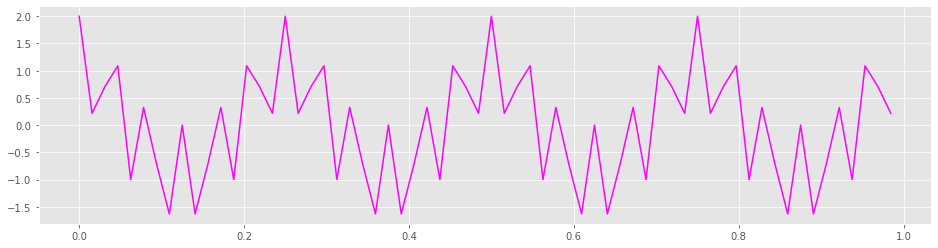

In [48]:
## Plot the compound sinusoid we've just created:
fig, timedom = plt.subplots(figsize=(16, 4))
timedom.plot(time_steps, x_noisy, color='magenta')


You should be able to see that the 4Hz cosine wave is perturbed by a 24 Hz cosine. So, this could represent a situation where there is high frequency noise in our signal that we'd like to get rid of.  Let's see if we can use our filter to smooth out this high frequency noise. 


### Apply the moving average filter

In [49]:
## Apply our moving average filter
y_mov = moving_average(x_noisy,K=5)

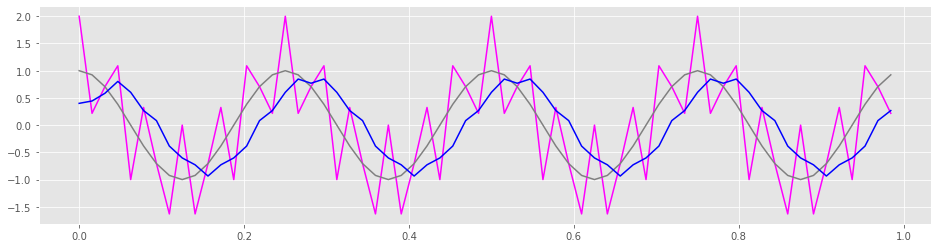

In [50]:
## Plot the results
fig, timedom = plt.subplots(figsize=(16, 4))

## The input signal
timedom.plot(time_steps, x_noisy, color='magenta')

## The underlying 4Hz signal
timedom.plot(time_steps, x1, color='grey')

## After the moving average has been applied
timedom.plot(time_steps, y_mov, color='blue')



You should see: 
* the original signal in magenta
* the low frequency cosine component in grey
* the output of the filter in blue

### Exercise: 

* Q: From the plot, does it appear that the moving average recovered the original 4Hz signal in terms of:
    * frequency
    * amplitude
    * phase
* Q: Are there still high frequency components in the filter output? 

Can you see some issues with applying this filter? What happens at the end points? Are they valid? 

### Notes

_add some answers or points to discuss with the tutors_

### Get the DFT of the filtered signal

We can apply the DFT to our output to check our observations from the time-domain output. 

In [51]:
## DFT of the original input
mags_x, phases_x = get_dft_mag_phase(x_noisy, N)

## DFT of the filter output
mags_y, phases_y = get_dft_mag_phase(y_mov, N)

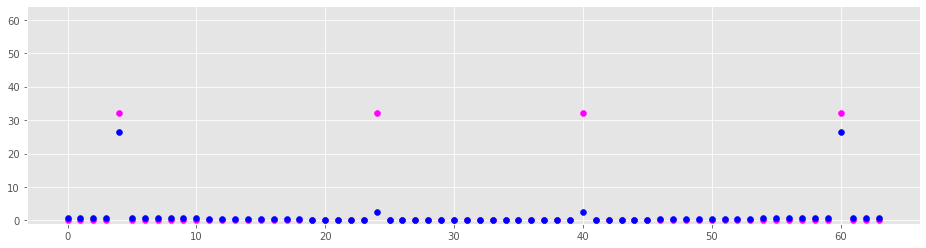

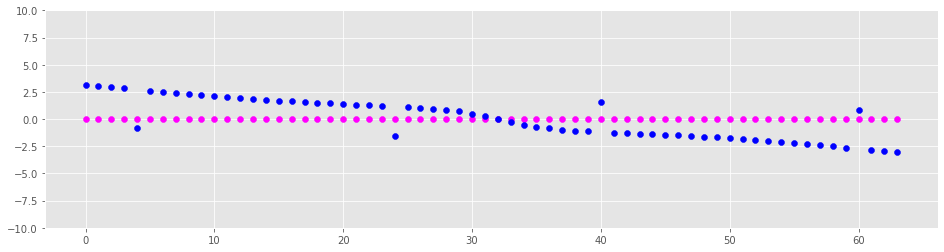

In [52]:
dft_freqs = get_dft_freqs(sample_rate=f_s, seq_len=N)

fig, mags = plt.subplots(figsize=(16, 4))
mags.set( ylim=(-1, N))
mags.scatter(dft_freqs, mags_x, color='magenta')
mags.scatter(dft_freqs, mags_y, color='blue')


fig, phases = plt.subplots(figsize=(16, 4))
phases.set(ylim=(-10, 10))
phases.scatter(dft_freqs, phases_x, color='magenta')
phases.scatter(dft_freqs, phases_y, color='blue')



### Exercise

* Based on the magnitude spectrum: 
    * Did the filter get rid of the 24Hz component? 
    * Do you see any signs of leakage? 
    
* Based on the phase spectrum: 
    * What happened to the phase of the 4Hz and 24Hz component? 
    * Why do we see more non-zero phases in the DFT of the filtered output?
    
* What happens if you change the frequency of the second sinusoid to something lower (e.g. 6Hz)? 

### Notes

## FIR as convolution

An *m-tap* FIR Filter has the following general form: 

$$ y[n] = \sum_{k=0}^{m-1} b[k] x[n-k] $$ 

So, we can theoretically set our filter to coefficients to whatever we want.  Here's a function that generalizes our moving average filter to allow for this:

In [53]:
def fir_filter(x, filter_coeffs):
    N = len(x)
    m = len(filter_coeffs)
    
    y = np.zeros(N)   
    for n in range(N):
        for k in range(m):
            if n-k >= 0: 
                #print("y[%d]=%f, b[%d]=%f, x[%d]=%f" % (n, y[n], k, filter_coeffs[k], n-k, x[n-k]))
                y[n] = y[n] + (filter_coeffs[k]*x[n-k])
        #print("y[%d]=%f" % (n, y[n]))
    return y    
    

### Changing the filter coefficients

Let's try it out with different coefficient values

In [54]:

## The 5-point moving average from before
h_avg = np.array([1/5, 1/5, 1/5, 1/5, 1/5])
y_avg = fir_filter(x_noisy, h_avg)

## A 5-point symmetrically weighted average 
h_wavg = np.array([1/5, 1/3, 1, 1/3, 1/5])
y_wavg = fir_filter(x_noisy, h_wavg)

### Filter effects in the time domain

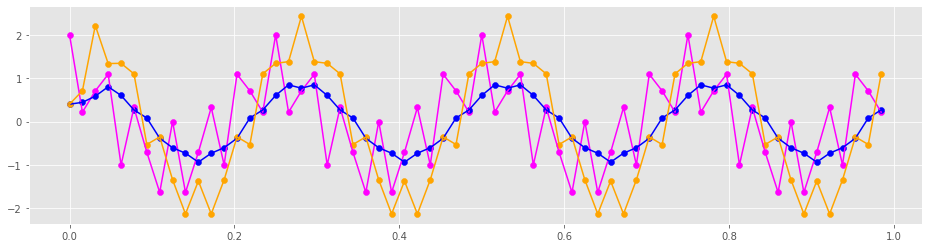

In [55]:
## Plot the filter outputs

fig, sinusoid = plt.subplots(figsize=(16, 4))

## The original "noisy" input
sinusoid.plot(time_steps, x_noisy, color='magenta')
sinusoid.scatter(time_steps, x_noisy, color='magenta')

## The 5-point moving average
sinusoid.plot(time_steps, y_avg, color='blue')
sinusoid.scatter(time_steps, y_avg, color='blue')

## The 5-point weighted average
sinusoid.plot(time_steps, y_wavg, color='orange')
sinusoid.scatter(time_steps, y_wavg, color='orange')


### Exercise

Q: Why is the output of $y_{wavg}$ more spikey than that of $y_{mavg}$?

Ans: The weight structure keeps more of the middle of the filter window.  This means the outputs are closer to the original (quite spikey) input, but with a phase delay since we're basing our current output on the $m$ previous inputs: a peak it the input won't get the highest weighting until 2 steps after we originally saw it.  

### Notes

_add your notes!_



## FIR Filters in the Frequency Domain


### DFT of the filtered outputs

We can look at the effect of the two FIR filters defined above in the frequency domain by performing a DFT on the filter outputs. 


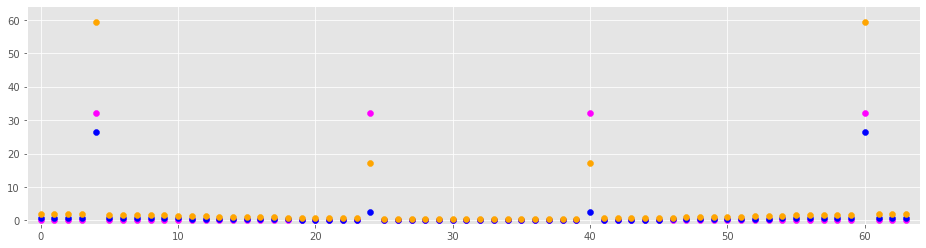

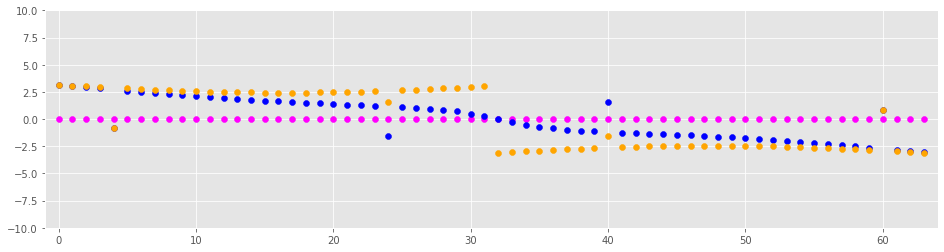

In [56]:
## DFT of the original input
mags_x, phases_x = get_dft_mag_phase(x_noisy, N)

## DFT after weighted average filter: h_wavg = np.array([1/5, 1/3, 1, 1/3, 1/5])
mags_wavg, phases_wavg = get_dft_mag_phase(y_wavg, N)

## DFT after unweighted average filter: h_avg = np.array([1/5, 1/5, 1/5, 1/5, 1/5])
mags_avg, phases_avg = get_dft_mag_phase(y_avg, N)

dft_freqs = get_dft_freqs(sample_rate=f_s, seq_len=N)



## Plot magnitude spectrums
fig, mags = plt.subplots(figsize=(16, 4))
mags.set(xlim=(-1, N), ylim=(-1, N))
mags.scatter(dft_freqs, mags_x, color='magenta')
mags.scatter(dft_freqs, mags_avg, color='blue')
mags.scatter(dft_freqs, mags_wavg, color='orange')


## Plot phase spectrums
fig, phases = plt.subplots(figsize=(16, 4))
phases.set(xlim=(-1, N), ylim=(-10, 10))
phases.scatter(dft_freqs, phases_x, color='magenta')
phases.scatter(dft_freqs, phases_avg, color='blue')
phases.scatter(dft_freqs, phases_wavg, color='orange')




### Exercise: 

Describe the difference between the different FIR filters based on the frequency magnitude and phases responses plotted above. 

* Does the weighted average filter do as good a job at filtering out the higher frequency signals? 

Ans: No it doesn't, but it does seem to amplify the lower frequency signals more. 

### Notes

_Your notes_


### Convolution in Time,  Multiplication in Frequency 

**FIX NOTATION, IDFT etc** 

Now we get to the really cool bit.  We know that the DFT allows us to go from the time domain to the frequency domain (and the IDFT let's us go back).  But it also has this very important property: 

$$ h[k] * x[n] \mapsto^{DFT} H(m) \cdot X(m) $$

That is, convolving an input sequence $x$ with a set of filter coefficients, $h$ in the time domain is the same as (pointwise) multiplication of the DFT of $h$ with the DFT of $x$.  So, if we know what type of frequency $h$ has, we can treat this as apply a sort of mask to the DFT of $x$.  

Note that you also get the opposite: 

$$ h[k] \cdot x[n] \mapsto^{DFT} H(m) * X(m) $$

This is useful for understanding why the leakage graph around each DFT bin looks the way it does. 

In fact, we can use to not only show that the moving average acts as a low pass filter, but also to be able to calculate exactly the type of filter it will be. 

### The moving average filter as a rectangular function

**add some notes**

If we know the frequency response of an FIR filter, we know how it will affect the frequency response of it's input. 

To understand what filter frequency response will look like, it's helpful to first observe that our unweighted moving average filter is pretty much a rectangular window function.  The following function allows us to generate rectangular functions:

In [57]:
def gen_rect_window(start_index, end_index, sample_rate=64, seq_length=64): 
    nsteps = np.array(range(seq_length))
    t_s = 1/sample_rate
    time_steps = t_s * nsteps

    ## Let's make a rectangular window
    x_rect = np.zeros(seq_length)
    x_rect[start_index:end_index] = 1
    
    return x_rect, time_steps


### Make a rectangular window

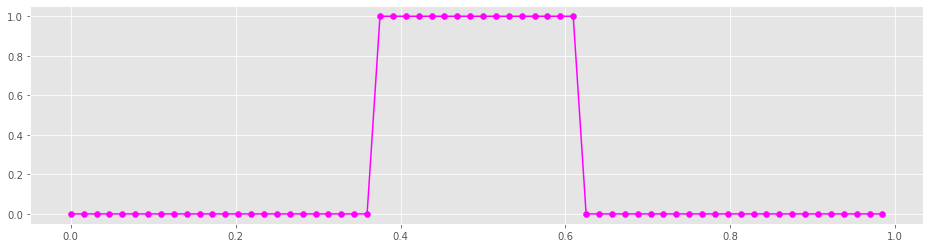

In [58]:
## Make rectangular window
N=64
K=16
f_s=64
start_index=24
end_index=start_index+K

x_rect, time_steps = gen_rect_window(start_index=start_index, end_index=end_index, sample_rate=f_s, seq_length=N)

fig, timedom = plt.subplots(figsize=(16, 4))
timedom.scatter(time_steps, x_rect, color='magenta')
timedom.plot(time_steps, x_rect, color='magenta')

### Look at the frequency response of the rectangular window

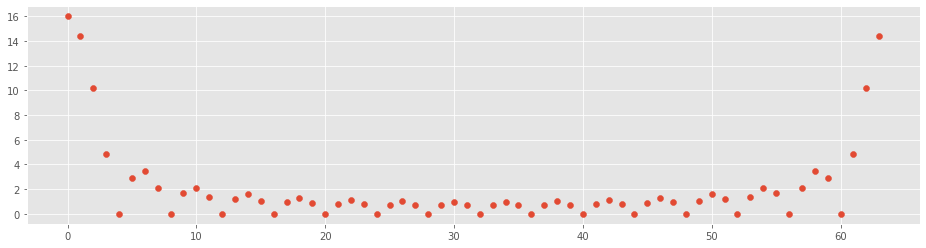

In [59]:
## Do the DFT on the rectangular function
mags_rect, phases_rect = get_dft_mag_phase(x_rect, N)

dft_freqs_rect = (f_s/N) * np.arange(N)

fig, fdom = plt.subplots(figsize=(16, 4))
fdom.scatter(dft_freqs_rect, mags_rect)

## Looks leaky! 

### Leaky windows? 

The plot of the frequency magnitude response of our rectangular window has the hallmarks of leakiness. That is, the frequency response looks scalloped, with the biggest peak occuring around 0Hz. That is, it looks like a low pass filter!  

This falls out from the maths of the DFT.  With a bit of algebra we can derive the frequency for any $m$ (not just the DFT output bins indices) as follows: 

If $x[n]$ is a rectangular function of N samples with $K$ continugous samples of value 1 (starting at index $n_0$), we can figure out what the DFT output will be using a some algebra.  Eventually you get this:

$$X[m] = e^{i(2\pi m/N)(n_0-(K-1)/2)} . \frac{\sin(2\pi mK/2N)}{\sin(2\pi m /2N)}$$

This is the **Dirichlet kernel**. It has the **sinc** shape we saw when we looked at spectral leakage. 

How is this useful?  Since we know what the frequency response of a rectangular window is, we know what convolving this with different input sequences will look like in the frequency domain.  We just multiply the frequency magnitude responses together. 

On a more general note, this sort of convolution with a (short) window is how we do frequency analysis of speech: we taking windows of speech (aka frames) through time and and apply the DFT to get a frequency response.  A rectangular window is the simplest type of window we can take.  The equation above tells us that the sinc shaped response is an inherent part of using this sort of window.  In fact, we can use other window types (e.g. Hanning) to make the main lobes shaper and the sidelobes flatter, but we never really get away from this sinc shape in real world applications.  This is a key component of this soft of **short term analysis**.  

  


In [60]:
def gen_rect_response(n_0, K, N, stepsize=0.01, polar=True, amplitude=1):
    ms = np.arange(0.01, N, stepsize)
    qs = 2*np.pi*ms/N 

    ## Infact, we can work the frequency response to be the Dirichlet Kernel:
    response = (np.exp(-1j*qs*(n_0-(K-1)/2)) * np.sin(qs*K/2))/np.sin(qs/2) 
    
    if polar: 
        response_polar = [cmath.polar(z) for z in response]
        mags = np.array([m for m, _ in response_polar]) * amplitude
        phases = np.array([ph if round(mag) > 0 else 0 for mag, ph in response_polar])
        return (mags, phases, ms)
        
    return response, ms
    

Let's plot the dirichlet kernel with the leaky looking DFT magnitudes we calculated earlier for our rectangular window.  You should be able to see that the DFT magnitudes appear as discrete samples of the Dirichlet Kernel



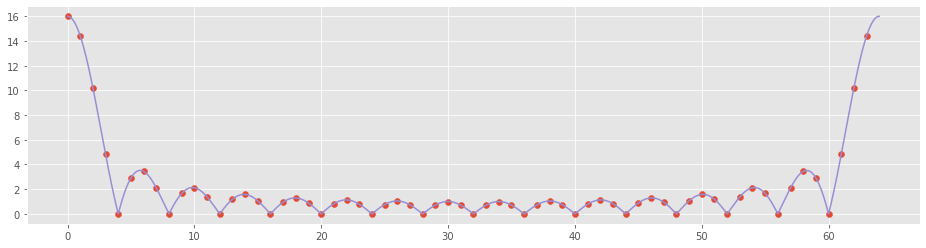

In [61]:
## Overlay the dirichlet kernel onto the DFT magnitudes we calculated earlier
## You should be able to see that the DFT magnitudes appear as discrete samples of the Dirichlet Kernel

mags_rect, phases_rect = get_dft_mag_phase(x_rect, N)
mags_rect_sinc , _ , ms = response = gen_rect_response(start_index, K, N)

fig, ax = plt.subplots(figsize=(16, 4))
ax.scatter(dft_freqs_rect, mags_rect)
ax.plot((f_s/N)*ms, mags_rect_sinc, color='C2')

### The unweighted average filter as a rectangular function

We can think of our 5-point unweighted average filter as a 5-point input sequence with all values set to 1/5.  We can then deduce that the frequency response of the filter will have the same shape as the frequency response of a rectangular window of all ones, but scaled down by 1/5.  

Now let's check: 

h_avg: [0.2 0.2 0.2 0.2 0.2]


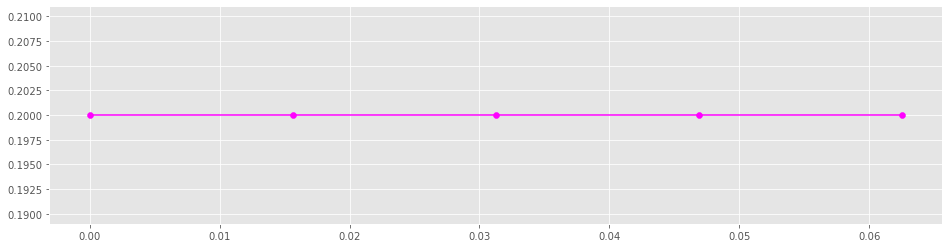

In [62]:
N_h=5 
f_s=64
start_index=0
end_index=N_h - start_index

## A 5 point rectangular window of all ones
h_avg, time_steps = gen_rect_window(start_index=start_index, end_index=end_index, sample_rate=f_s, seq_length=N_h)
h_avg = h_avg/N_h

fig, td = plt.subplots(figsize=(16, 4))
td.scatter(time_steps, h_avg, color='magenta')
td.plot(time_steps, h_avg, color='magenta')

## Not very exciting looking! 
print("h_avg:", h_avg)

Now, we can plot the DFT magnitude response, as well as it's idealized continuous version: 

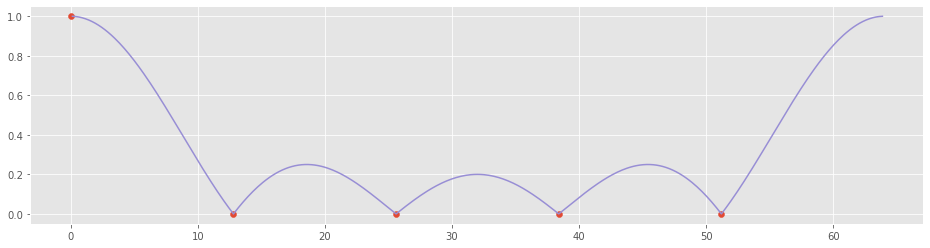

In [63]:
## Get the frequency magnitude response for our rectangular function
mags_h_avg, phases_h_avg = get_dft_mag_phase(h_avg, N_h)

## Get the continuous 
rect_mags_h_avg, _ , ms = gen_rect_response(start_index, N_h, N_h, amplitude=np.max(h_avg)) 


## x-axis as frequencies rather than indices
ms_freqs_h_avg = (f_s/N_h) * ms
dft_freqs_h_avg = (f_s/N_h) * np.arange(N_h)

## Plot the frequency magnitude response
fig, fd = plt.subplots(figsize=(16, 4))
fd.scatter(dft_freqs_h_avg, mags_h_avg)
#fd.scatter(dft_freqs_rect, mags_rect)

fd.plot(ms_freqs_h_avg, rect_mags_h_avg, color="C2")

### Exercise

So the problem is that our DFT components sit exactly at the zeros of this function when K=N

**to add something* 


### Matching the filter and input size

The theorem we saw above told us that we could calculate the frequency response of applying the FIR filter to an input sequence (via convolution), but multiply the DFT outputs of the filter and the input sequence.  

Now, the x-axis range matches our that of our noisy input sequence because that is determined by the sampling rate. However, the filter frequency response we have above only has 5 outputs, while our input sample size was 64 because the number of DFT outputs is determined by the number of samples we put into the DFT.  

To get things in the right form, we need to do some **zero padding** of the filter. We'll see that this basically gives us more samples of the Dirichlet Kernel corresponding to the filter frequency response. 




### Zero padding the filter

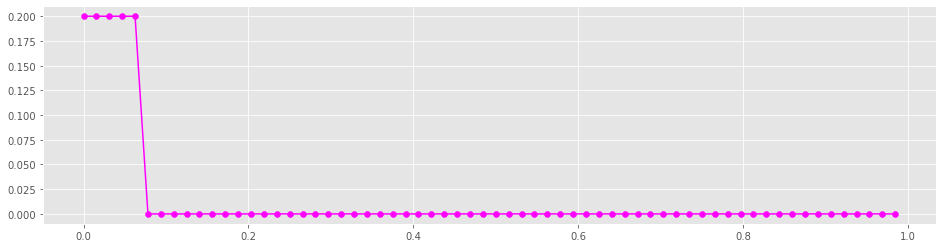

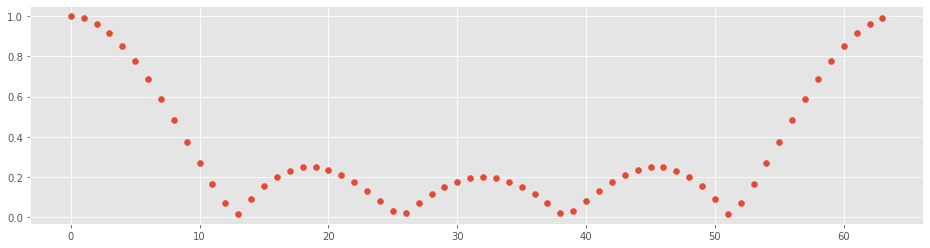

In [64]:
N=64
K=5
f_s=64
start_index=0
end_index=K

## Make a rectangular filter: K ones at the start
h_avg_pad, time_steps = gen_rect_window(start_index=start_index, end_index=end_index, sample_rate=f_s, seq_length=N)

## Divide by K to make it an average
h_avg_pad = h_avg_pad/K

## Plot the filter
fig, td = plt.subplots(figsize=(16, 4))
td.scatter(time_steps, h_avg_pad, color='magenta')
td.plot(time_steps, h_avg_pad, color='magenta')

#print("N=%d, K=%d, start=%d, end=%d" % (N, K, start_index, end_index))

## Get the frequency magnitude response for our rectangular function
mags_havg, phases_havg = get_dft_mag_phase(h_avg_pad, N)

## Plot the frequency magnitude response 
## x-axis as actual frequencies rather that DFT indices
dft_freqs_havg = (f_s/N) * np.arange(N)

fig, fd = plt.subplots(figsize=(16, 4))
fd.scatter(dft_freqs_havg, mags_havg)


You should be able to see more clearly in the frequency response graph that the zero padding doesn't change doesnt change the basic shape of the filter's frequency response, we just get a finer grained representation. 

### Input and filter frequency responses

In [65]:
## Now let's calculate frequency responses of the original input
mags, phases = get_dft_mag_phase(x_noisy, N)

## ...  the filter
mags_filter, phases_filter = get_dft_mag_phase(h_avg_pad, N)

## ... and the filtered output that we calculated above
mags_avg, phases_avg = get_dft_mag_phase(y_avg, N)

## Plot with actual frequencies on the x-axis
dft_freqs = get_dft_freqs(f_s, N)

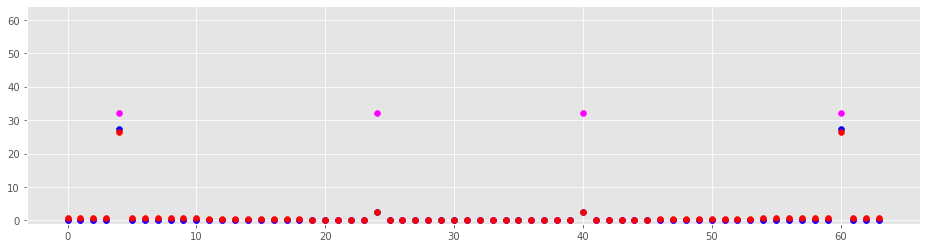

In [66]:
## plot frequency responses

fig, fd = plt.subplots(figsize=(16, 4))
fd.set(ylim=(-1, N))

# DFT(input)
fd.scatter(dft_freqs, mags, color='magenta')

# DFT(filter) * DFT(input)
fd.scatter(dft_freqs, mags_filter*mags, color='blue')

# DFT(filtered input)
fd.scatter(dft_freqs, mags_avg, color='red')

You should see that the results from multiplying the DFT magnitudes from the input and the filter (blue) is (more or less) the same as the DFT of applying the filter in th time domain via convolution (red)

* Notice that there are some differences between the results from the time domain application of the filter (red) and the frequency domain multiplication (blue).  In particular there appears to be some leakage in the time-domain convolution case, possibly due to floating point errors.

### Exercise

* Try changing the frequency of the second cosine component of our compound wave. 
    * Does the amount of attenuation of the high frequency component change as suggested by the DFT of the filter? 
    * e.g. try 26 Hz vs 19 Hz
* What does this tell you about how well this low pass filter get's rid of high frequency noise?



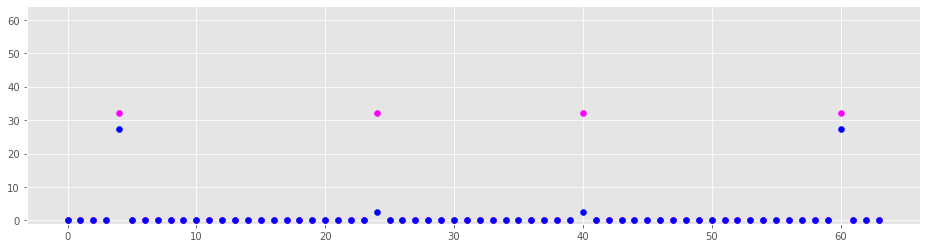

In [67]:
## Change the frequency of x2

x1, time_steps = gen_sinusoid(frequency=4, phase=0, amplitude=1, sample_rate=f_s, seq_length=N, gen_function=np.cos)
x2, time_steps = gen_sinusoid(frequency=24, phase=0, amplitude=1, sample_rate=f_s, seq_length=N, gen_function=np.cos)

# add them up!
x_noisy = x1 + x2

## Now let's calculate frequency responses of the original input
mags, phases = get_dft_mag_phase(x_noisy, N)

## ...  the filter
mags_filter, phases_filter = get_dft_mag_phase(h_avg_pad, N)

## Plot with actual frequencies on the x-axis
dft_freqs = get_dft_freqs(f_s, N)

## plot frequency responses

fig, fd = plt.subplots(figsize=(16, 4))
fd.set(ylim=(-1, N))

# DFT(input)
fd.scatter(dft_freqs, mags, color='magenta')

# DFT(filter) * DFT(input)
fd.scatter(dft_freqs, mags_filter*mags, color='blue')


### Notes

### Plotting different FIR filter frequency responses

### Exercise
* Run the function plot_filter_freq_responses (defined in the next cell) to plot the frequency responses of filters with different shapes (e.g. h_plat, h_tri, h_rect).  
    * What's the difference in frequency response of the triangular filter and the rectangular filter? 
    * What's the difference between the moving average of size 5 and one of size 9 (h_rect9)? 
    * Try some other FIR filters! 

In [68]:

def plot_filter_freq_responses(filters, sample_rate, seq_length):

    dft_freqs_filter = (f_s/N) * np.arange(N)
    
    fig_time, sinusoid = plt.subplots(figsize=(16, 4))
    fig_freq, fresponse = plt.subplots(figsize=(16, 4))
  
    x_filters = {}
    for i, h in enumerate(filters): 
        x_zeros = np.zeros(seq_length - len(h))
        x = np.concatenate([h, x_zeros])
        mags, phases = get_dft_mag_phase(x, seq_length)
        
        sinusoid.scatter(time_steps, x)
        sinusoid.plot(time_steps, x)

        fresponse.scatter(dft_freqs_filter, mags)
        fresponse.plot(dft_freqs_filter, mags)
        
        x_filters = {'x':x, 'mags':mags, 'phases':phases, 'coeffs':h}




    return x_filters


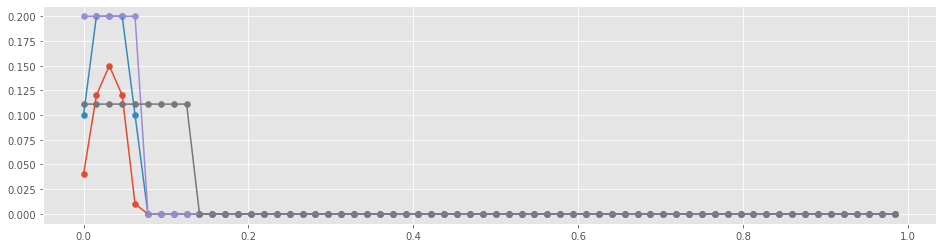

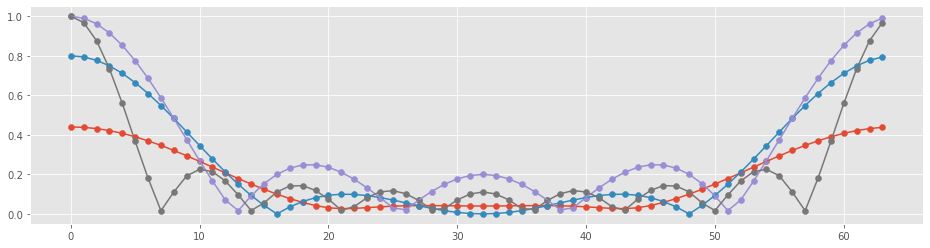

In [69]:
h_plat = np.array([0.1, 0.2, 0.2, 0.2, 0.1])
h_tri = np.array([0.04, 0.12, 0.15, 0.12, 0.01])
h_rect = np.array([1/5, 1/5, 1/5, 1/5, 1/5])
h_rect9 = np.array([1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9, 1/9])
## Try some others if you like!

N=64
f_s=64

filter_dict = plot_filter_freq_responses(filters=[h_tri, h_plat, h_rect, h_rect9], sample_rate=f_s, seq_length=N)

### Notes



## Applying an FIR filter to an impulse train

Now, let's look at the effect of applying an FIR filter to an impulse train.  Remember, we're using impulse trains to represent source (i.e. vocal pulses at a specific frequency).  Eventually, we want to be able to define filters that capture the effects of the vocal tract.  

First, here's a function that produces a sequence of pulses at a given frequency and sample rate. We'll then apply a triangular filter and look at what the frequency response is of the output is. 

In [70]:
## Let's make an impulse train
N=200
f_s = 8000
t_s = 1/f_s

frequency = 200

x_imp, time_steps = make_impulse_train(sample_rate=f_s, frequency=frequency, n_samples=N)


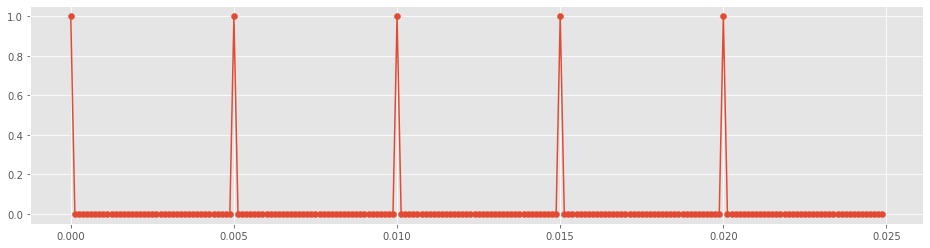

In [71]:
## Plot the impulse train made in the cell before
fig, td = plt.subplots(figsize=(16, 4))
td.scatter(time_steps, x_imp)
td.plot(time_steps, x_imp)

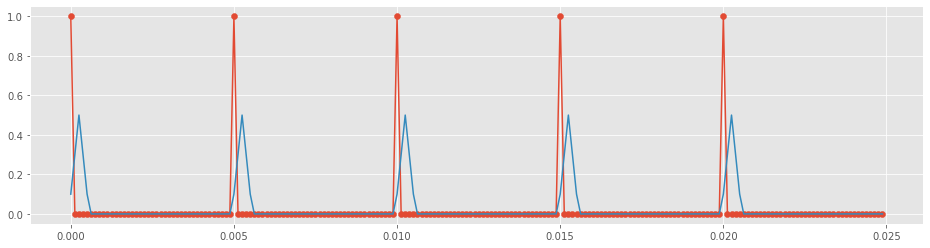

In [72]:
## define our FIR filter coefficients
h_mov = np.array([0.1, 0.3, 0.5, 0.3, 0.1])

#try this later!
#h_mov = np.array([1])


## Apply the filter to our impulse train
y_mov = fir_filter(x_imp, h_mov)

## plot the impulse train and the filtered version of it
fig, td = plt.subplots(figsize=(16, 4))
td.scatter(time_steps, x_imp)
td.plot(time_steps, x_imp)
td.plot(time_steps, y_mov)

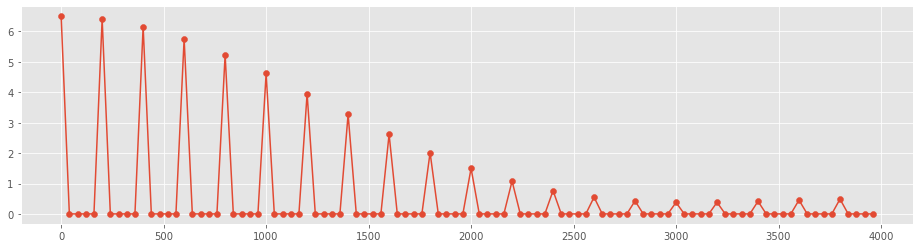

In [73]:
## Get the DFT the filter output
mags, phases = get_dft_mag_phase(y_mov, N)

## Plot the DFT frequencies rather than DFT output indices
dft_freqs = get_dft_freqs(f_s, N)

## Plot the magnitude spectrum
fig, ax = plt.subplots(figsize=(16, 4))
ax.scatter(dft_freqs[0:int(N/2)],mags[0:int(N/2)])
ax.plot(dft_freqs[0:int(N/2)], mags[0:int(N/2)])


### Exercises

**[harmonics, f0]**

* What do the spikes in the DFT outputs represent? 
* What does the first spike after the 0 frequency one represent? 
* What does this filter appear to do?
    * Remember applying the FIR filter in the time domain (via convolution) is the same as multiplying the DFT of the filter to the DFT of the input signal

### Notes

### Exercises 

* What happens when the impulse train frequency doesn't fall on one of the bins? e.g. frequency = 130, for 200 samples, with sampling rate 8000
    * Does the magnitude spectrum have the harmonic structure you'd expect? 

### Notes

## <span style="color:red">Designing an FIR filter</span>

* Say what type of spectrum we want
* Use IDFT to get coefficients

What are this issues with this? 

In [74]:
## What's the impulse response of our moving average filter? 

## What happens when you change the length of x_impulse?
x_impulse = np.zeros(5)
#x_impulse = np.zeros(16)

## What happens when you can the position of the impulse in the window? 
x_impulse[3] = 1

y_mov = fir_filter(x_impulse, h_tri)
y_mov

## It gives us our coefficients back! 

array([0.  , 0.  , 0.  , 0.04, 0.12])